# Capstone 3: Keras Image Classification Model<a id='KICM'></a>

## Contents<a id='Contents'></a>
* [Keras Image Classification Model](#KICM)
  * [Contents](#Contents)
  * [Introduction](#Introduction)
  * [Imports](#Imports)
  * [Data Wrangling and Exploratory Data Analysis](#DWEDA)  
      * [Load the Data](#Load_the_Data)
      * [Data Wrangling](#Data_Wrangling)
      * [Image Analysis](#Image_Analysis)
      * [Data Definition](#Data_Definition)

## Introduction<a id='Introduction'></a>

It can often be beneficial to use machine learning to supplement the work done by doctors in diagnosing cases where the problem can be visually seen either externally with images or internally using different X-ray and CT imaging techniques. The machine learning applications by no means replace the diagnosis of a trained medical professional, but can be useful in preliminary screening as well as differentiating conditions, especially those which are often close in appearance. This can also help to reduce medical staff workload, especially in areas where medical personnel are stretched thin.

## Imports<a id='Imports'></a>

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import tensorflow as tf
import skimage as sk
from skimage import color, filters, exposure, data, transform, morphology, restoration, util, segmentation, measure, feature

C:\Users\jmhat\AppData\Roaming\Python\Python38\site-packages\dask\config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Data Wrangling and Exploratory Data Analysis<a id='DWEDA'></a>

### Load the Data<a id='Load_the_Data'></a>

In [2]:
#At this stage, I'll only import the metadata file
image_metadata = pd.read_csv('C:/Users/jmhat/Desktop/Coding/Capstone3/Data/HAM10000_metadata.csv')

The metadata dataframe contains information on the lesion id, image id, diagnosis (dx), diagnosis method (dx_type), age, sex, and location of the lesion (localization). <br>

There are 7 different types of lesions in the dataset including: <br>
> akiec - Actinic keratoses and intraepithelial carcinoma/Bowen's disease <br>
bcc - Basal cell carcinoma <br>
bkl - Benign keratosis-like lesions (solar lentigines/seborrheic keratoses and lichen-planus-like keratoses <br>
df - Dermatofibroma <br>
mel - Melanoma <br>
nv - Melanocytic nevi <br>
vasc - Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)

There are 4 different types of diagnosis methods in the dataset including: <br>
> histo - Histopathology <br>
follow_up - Follow-up examination <br>
consensus - Expert consensus <br>
confocal - In-vivo confocal microscopy <br>

In [3]:
image_metadata.shape

(10015, 7)

In [4]:
image_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Data Wrangling<a id='Data_Wrangling'></a>

In [5]:
#Rename the dx, dx_type, and localization columns to make them clearer
image_metadata.rename(columns={'dx': 'diagnosis', 'dx_type':'diagnosis_method', 'localization':'location'}, inplace=True)

In [6]:
image_metadata.head()

,lesion_id,image_id,diagnosis,diagnosis_method,age,sex,location
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
image_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lesion_id         10015 non-null  object 
 1   image_id          10015 non-null  object 
 2   diagnosis         10015 non-null  object 
 3   diagnosis_method  10015 non-null  object 
 4   age               9958 non-null   float64
 5   sex               10015 non-null  object 
 6   location          10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


A preliminary look at the data shows there are at least 57 ages missing and possibly other values mislabeled in the other columns. I'll use the value counts function to inspect the columns of interest. I'll make one long string for these values, meaning I need to convert age to a string as well and then add them all together. I will use a copy of the original dataset for this work so as to not disturb the original data.

In [8]:
image_metadata_copy = image_metadata.copy()

In [9]:
image_metadata_copy = image_metadata_copy.astype({'age': 'str'})

In [10]:
image_metadata_copy['diag_method_age_sex_location'] = image_metadata_copy['diagnosis'] + ' ' + image_metadata_copy['diagnosis_method'] + ' ' + image_metadata_copy['age'] + ' ' + image_metadata_copy['sex'] + ' ' + image_metadata_copy['location']

In [11]:
pd.options.display.max_rows = 1450

In [12]:
image_metadata_copy['diag_method_age_sex_location'].value_counts()

nv follow_up 45.0 female trunk                130
nv follow_up 45.0 female lower extremity      122
nv follow_up 50.0 male trunk                  112
nv follow_up 50.0 female trunk                107
nv follow_up 45.0 male lower extremity         93
nv follow_up 50.0 female lower extremity       88
nv follow_up 45.0 male trunk                   85
nv follow_up 55.0 female lower extremity       85
nv follow_up 40.0 female trunk                 74
nv follow_up 40.0 male trunk                   71
nv follow_up 50.0 male lower extremity         67
nv follow_up 40.0 female lower extremity       65
nv follow_up 45.0 male back                    65
nv follow_up 55.0 male trunk                   65
nv follow_up 55.0 male lower extremity         62
nv follow_up 35.0 male lower extremity         60
nv follow_up 50.0 male abdomen                 59
nv follow_up 55.0 female trunk                 58
nv follow_up 45.0 male abdomen                 57
nv follow_up 45.0 female abdomen               56


After inspecting the above value counts, along with the missing ages, there are also many 'unknown' entries. I will replace the 'unknown' entries and missing ages with the most common for each category below

In [13]:
#Replace missing values with most common entry for the remaining columns
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 55.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 25.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 35.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'abdomen'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 35.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 55.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'abdomen'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 75.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 70.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 10.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 30.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 30.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 55.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 75.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 80.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 35.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 85.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 85.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bcc') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 70.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 80.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'confocal') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'face'
image_metadata.loc[(image_metadata['diagnosis'] == 'bcc') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 50.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 70.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 75.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 50.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 65.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 70.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 50.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 50.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'face'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 75.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 80.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 55.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bcc') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'foot'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 25.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'

image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 60.0) & (image_metadata['location'] == 'foot') & (image_metadata['sex'] == 'unknown'), 'sex'] = 'female'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 35.0) & (image_metadata['location'] == 'trunk') & (image_metadata['sex'] == 'unknown'), 'sex'] = 'female'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 45.0) & (image_metadata['location'] == 'abdomen') & (image_metadata['sex'] == 'unknown'), 'sex'] = 'male'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 0.0) & (image_metadata['location'] == 'back') & (image_metadata['sex'] == 'unknown'), 'sex'] = 'male'


In [14]:
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'trunk') & (image_metadata['age'].isnull() == True), 'age'] = 35.0
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'abdomen') & (image_metadata['age'].isnull() == True), 'age'] = 35.0
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'face') & (image_metadata['age'].isnull() == True), 'age'] = 65.0
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'foot') & (image_metadata['age'].isnull() == True), 'age'] = 0.0
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'chest') & (image_metadata['age'].isnull() == True), 'age'] = 25.0
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'upper extremity') & (image_metadata['age'].isnull() == True), 'age'] = 45.0

In [15]:
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'].isnull() == True) & (image_metadata['sex'] == 'unknown') & (image_metadata['location'] == 'unknown'), ['age', 'sex', 'location']] = [70.0, 'female', 'trunk']
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'].isnull() == True) & (image_metadata['sex'] == 'unknown') & (image_metadata['location'] == 'unknown'), ['age', 'sex', 'location']] = [40.0, 'female', 'lower extremity']

Now that these have been replaced, I'll double check the values to ensure I am not missing any ages or unknown entries.

In [16]:
#Check values again
image_metadata_updated_copy = image_metadata.copy()
image_metadata_updated_copy = image_metadata_updated_copy.astype({'age': 'str'})
image_metadata_updated_copy['diag_method_age_sex_location'] = image_metadata_updated_copy['diagnosis'] + ' ' + image_metadata_updated_copy['diagnosis_method'] + ' ' + image_metadata_updated_copy['age'] + ' ' + image_metadata_updated_copy['sex'] + ' ' + image_metadata_updated_copy['location']
pd.options.display.max_rows = 1450
image_metadata_updated_copy['diag_method_age_sex_location'].value_counts()

nv follow_up 45.0 female trunk                131
nv follow_up 45.0 female lower extremity      122
nv follow_up 50.0 male trunk                  113
nv follow_up 50.0 female trunk                109
nv follow_up 45.0 male lower extremity         93
nv consensus 40.0 female lower extremity       89
nv follow_up 55.0 female lower extremity       88
nv follow_up 50.0 female lower extremity       88
nv follow_up 45.0 male trunk                   85
nv follow_up 40.0 female trunk                 74
nv follow_up 40.0 male trunk                   71
nv follow_up 50.0 male lower extremity         67
nv follow_up 55.0 male trunk                   65
nv follow_up 45.0 male back                    65
nv follow_up 40.0 female lower extremity       65
nv follow_up 55.0 male lower extremity         62
nv follow_up 35.0 male lower extremity         60
nv follow_up 50.0 male abdomen                 59
nv follow_up 55.0 female trunk                 58
nv follow_up 45.0 male abdomen                 57


In [17]:
image_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lesion_id         10015 non-null  object 
 1   image_id          10015 non-null  object 
 2   diagnosis         10015 non-null  object 
 3   diagnosis_method  10015 non-null  object 
 4   age               10015 non-null  float64
 5   sex               10015 non-null  object 
 6   location          10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [18]:
image_metadata.head()

,lesion_id,image_id,diagnosis,diagnosis_method,age,sex,location
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [19]:
image_metadata['diagnosis'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: diagnosis, dtype: int64

In [20]:
image_metadata['diagnosis_method'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: diagnosis_method, dtype: int64

In [21]:
image_metadata['sex'].value_counts()

male      5410
female    4605
Name: sex, dtype: int64

In [22]:
image_metadata['location'].value_counts()

back               2263
lower extremity    2178
trunk              1421
upper extremity    1136
abdomen            1031
face                748
chest               407
foot                334
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: location, dtype: int64

In [23]:
image_metadata.duplicated().value_counts()

False    10015
dtype: int64

The metadata is now complete with no missing values. However, the lesion_id column doesn't add much benefit to our classification model, so I will remove it to simplify the process moving forward.

In [24]:
#Drop the lesion_id column since this doesn't add any extra data to our model
image_metadata.drop('lesion_id', axis=1, inplace=True)

In [25]:
image_metadata.head()

,image_id,diagnosis,diagnosis_method,age,sex,location
0,ISIC_0027419,bkl,histo,80.0,male,scalp
1,ISIC_0025030,bkl,histo,80.0,male,scalp
2,ISIC_0026769,bkl,histo,80.0,male,scalp
3,ISIC_0025661,bkl,histo,80.0,male,scalp
4,ISIC_0031633,bkl,histo,75.0,male,ear


For the classification model, I need to use diagnosis as my target variable, and the image, diagnosis_method, age, sex, and location as features. 

Before creating a model that contains both the images and features from the metadata, I will first do a simple classification problem using just the images and diagnoses. I'm now going to replace the string values for diagnosis with numerical values.

In [26]:
image_metadata['diagnosis'] = image_metadata['diagnosis'].replace(['akiec','bcc','bkl','df','mel','nv','vasc'],[0, 1, 2, 3, 4, 5, 6])

In [27]:
image_metadata.head()

,image_id,diagnosis,diagnosis_method,age,sex,location
0,ISIC_0027419,2,histo,80.0,male,scalp
1,ISIC_0025030,2,histo,80.0,male,scalp
2,ISIC_0026769,2,histo,80.0,male,scalp
3,ISIC_0025661,2,histo,80.0,male,scalp
4,ISIC_0031633,2,histo,75.0,male,ear


In order to run a basic keras model with the images alone, I need to sort the images into subfolders by diagnosis.

In [28]:
#In order to sort the data into different folders, we need lists of image_id for each diagnosis
diag_akiec = image_metadata.query('diagnosis == 0')['image_id']
diag_akiec = list(diag_akiec + '.jpg')

In [29]:
diag_bcc = image_metadata.query('diagnosis == 1')['image_id']
diag_bcc = list(diag_bcc + '.jpg')

In [30]:
diag_bkl = image_metadata.query('diagnosis == 2')['image_id']
diag_bkl = list(diag_bkl + '.jpg')

In [31]:
diag_df = image_metadata.query('diagnosis == 3')['image_id']
diag_df = list(diag_df + '.jpg')

In [32]:
diag_mel = image_metadata.query('diagnosis == 4')['image_id']
diag_mel = list(diag_mel + '.jpg')

In [33]:
diag_nv = image_metadata.query('diagnosis == 5')['image_id']
diag_nv = list(diag_nv + '.jpg')

In [34]:
diag_vasc = image_metadata.query('diagnosis == 6')['image_id']
diag_vasc = list(diag_vasc + '.jpg')

In [54]:
source_1 = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/HAM10000_images_part_1'
source_2 = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/HAM10000_images_part_2'
dest_akiec = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/akiec'
dest_bcc = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/bcc'
dest_bkl = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/bkl'
dest_df = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/df'
dest_mel = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/mel'
dest_nv = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/nv'
dest_vasc = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/vasc'

files_1 = os.listdir(source_1)
files_2 = os.listdir(source_2)


for a in files_1:
    if a in diag_akiec:
        shutil.move(source_1 + '\\' + a, dest_akiec)
        
for b in files_2:
    if b in diag_akiec:
        shutil.move(source_2 + '\\' + b, dest_akiec)
        
for c in files_1:
    if c in diag_bcc:
        shutil.move(source_1 + '\\' + c, dest_bcc)
        
for d in files_2:
    if d in diag_bcc:
        shutil.move(source_2 + '\\' + d, dest_bcc)
        
for e in files_1:
    if e in diag_bkl:
        shutil.move(source_1 + '\\' + e, dest_bkl)
        
for f in files_2:
    if f in diag_bkl:
        shutil.move(source_2 + '\\' + f, dest_bkl)
        
for g in files_1:
    if g in diag_df:
        shutil.move(source_1 + '\\' + g, dest_df)
        
for h in files_2:
    if h in diag_df:
        shutil.move(source_2 + '\\' + h, dest_df)
        
for i in files_1:
    if i in diag_mel:
        shutil.move(source_1 + '\\' + i, dest_mel)
        
for j in files_2:
    if j in diag_mel:
        shutil.move(source_2 + '\\' + j, dest_mel)
        
for k in files_1:
    if k in diag_nv:
        shutil.move(source_1 + '\\' + k, dest_nv)
        
for l in files_2:
    if l in diag_nv:
        shutil.move(source_2 + '\\' + l, dest_nv)

for m in files_1:
    if m in diag_vasc:
        shutil.move(source_1 + '\\' + m, dest_vasc)
        
for n in files_2:
    if n in diag_vasc:
        shutil.move(source_2 + '\\' + n, dest_vasc)

### Image Analysis<a id='Image_Analysis'></a>

There are 10,015 images which correspond to the entries of in the metadata file. I first want to take a look at the images to determine the best path forward with incorporating the images.

In [35]:
def display_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [36]:
image1 = plt.imread('C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/nv/ISIC_0024306.jpg')

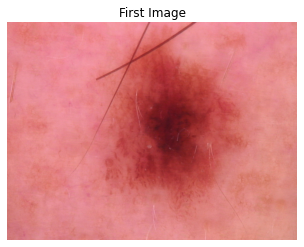

In [37]:
display_image(image1, 'First Image')

In [38]:
#Image size in pixels
image1.shape

(450, 600, 3)

In [39]:
#Total number of pixels
image1.size

810000

In [40]:
#Slice image into red, green, and blue channels
red = image1[:, :, 0]
green = image1[:, :, 1]
blue = image1[:, :, 2]

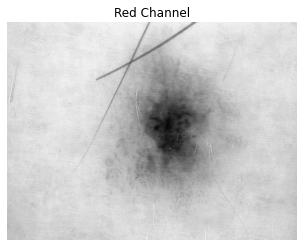

In [41]:
#Display image using red, green, and blue channels as grayscale images
plt.imshow(red, cmap='gray')
plt.title('Red Channel')
plt.axis('off')
plt.show()

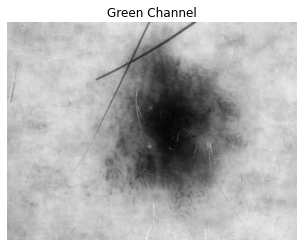

In [42]:
plt.imshow(green, cmap='gray')
plt.title('Green Channel')
plt.axis('off')
plt.show()

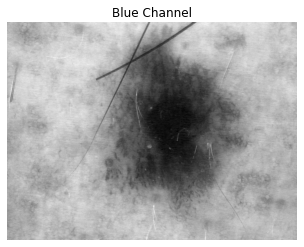

In [43]:
plt.imshow(blue, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')
plt.show()

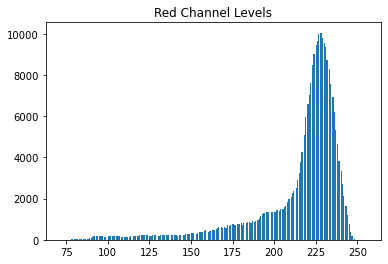

In [44]:
#Histogram of images
plt.hist(red.ravel(), bins=256)
plt.title('Red Channel Levels')
plt.show()

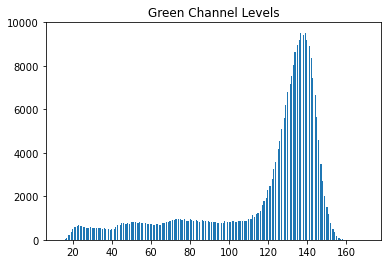

In [45]:
plt.hist(green.ravel(), bins=256)
plt.title('Green Channel Levels')
plt.show()

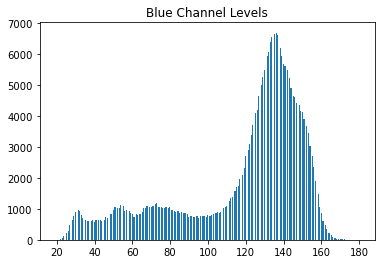

In [46]:
plt.hist(blue.ravel(), bins=256)
plt.title('Blue Channel Levels')
plt.show()

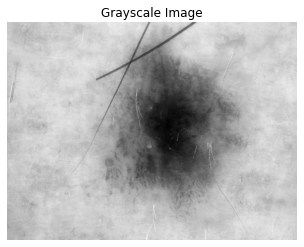

In [50]:
#Turn image to grayscale
grayscale_image1 = sk.color.rgb2gray(image1)
display_image(grayscale_image1, 'Grayscale Image')

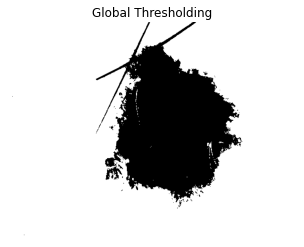

In [51]:
#Apply thresholds
thresh = sk.filters.threshold_otsu(grayscale_image1)
binary_global = grayscale_image1 > thresh
display_image(binary_global, 'Global Thresholding')

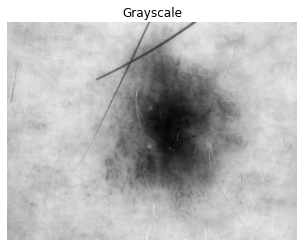

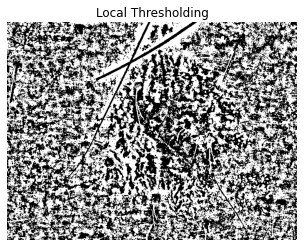

In [52]:
#Apply local threshold
block_size = 35
local_thresh = sk.filters.threshold_local(grayscale_image1, block_size)
binary_local = grayscale_image1 > local_thresh
display_image(grayscale_image1, 'Grayscale')
display_image(binary_local, 'Local Thresholding')

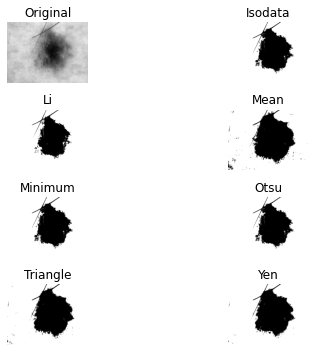

In [53]:
#Apply more thresholdings
fig, ax = sk.filters.try_all_threshold(grayscale_image1, verbose=False)
plt.show()

Some thresholding types worked better than others in isolated the affected skin area, but with each, other features, such as hair, is also picked up and may adversely affect the model.

In [54]:
#Apply edge detection
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,6), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

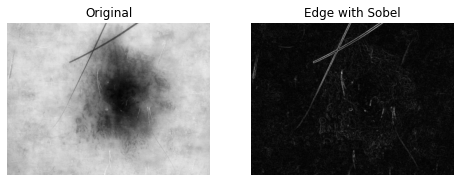

In [55]:
#Sobel edge detection
edge_sobel = filters.sobel(grayscale_image1)
plot_comparison(grayscale_image1, edge_sobel, 'Edge with Sobel')

Edges using Sobel didn't quite show any useful data, so I will process the image further to see if other edge representations work more effectively.

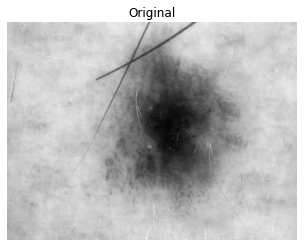

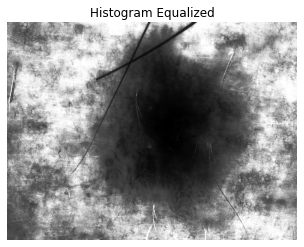

In [56]:
#Apply equalization to the exposure
image_eq = exposure.equalize_hist(grayscale_image1)
display_image(grayscale_image1, 'Original')
display_image(image_eq, 'Histogram Equalized')

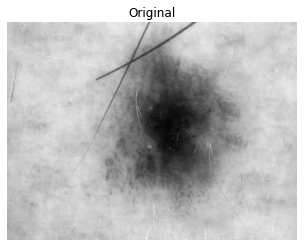

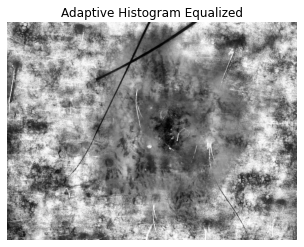

In [57]:
#Apply adaptive equalization to the exposure
image_adeq = exposure.equalize_adapthist(grayscale_image1, clip_limit=0.03)
display_image(grayscale_image1, 'Original')
display_image(image_adeq, 'Adaptive Histogram Equalized')

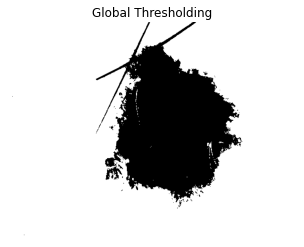

In [58]:
#Apply Isodata thresholds
thresh_iso = filters.threshold_isodata(grayscale_image1)
binary_global_iso = grayscale_image1 > thresh_iso
display_image(binary_global_iso, 'Global Thresholding')

In [59]:
def show_image_contour(image, contours):
    plt.figure()
    for n, contour in enumerate(contours):
        plt.plot(contour[:,1], contour[:,0], linewidth=3)
    plt.imshow(image, interpolation='nearest', cmap='gray_r')
    plt.title('Contours')
    plt.axis('off')
    plt.show()

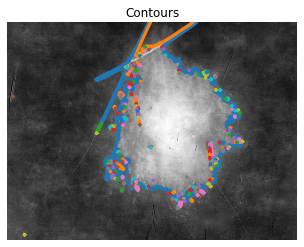

In [60]:
#Display lesion contours
contours = measure.find_contours(binary_global_iso, 0.8)
show_image_contour(grayscale_image1, contours)

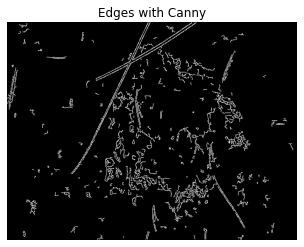

In [61]:
#Edges with Canny
canny_edges = feature.canny(grayscale_image1, sigma=0.0)
display_image(canny_edges, 'Edges with Canny')

After reviewing the different image processing options available, we can see that each option provides different kinds of information about the lesion. Some of this data may be especially helpful in visual classification and spread of the lesion on the patient's skin. However, since skin lesions often have different colors as well as shapes, it may still be more beneficial to feed the color images to our model for analysis. 

### Data Definition<a id='Data_Definition'></a>

Let's convert all the values to numerical features

In [62]:
metadata_numeric = image_metadata.copy()

In [63]:
#Replace categorical variables with get_dummies method
metadata_numeric = pd.get_dummies(metadata_numeric, columns=['diagnosis'], drop_first=False)

In [64]:
metadata_numeric = pd.get_dummies(metadata_numeric, columns=['diagnosis_method'], drop_first=False)

In [65]:
metadata_numeric = pd.get_dummies(metadata_numeric, columns=['sex'], drop_first=False)

In [66]:
metadata_numeric = pd.get_dummies(metadata_numeric, columns=['location'], drop_first=False)

In [67]:
#metadata_numeric['diagnosis'] = metadata_numeric['diagnosis'].replace(['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
#metadata_numeric['diagnosis_method'] = metadata_numeric['diagnosis_method'].replace(['histo', 'follow_up', 'consensus', 'confocal'], [1.0, 2.0, 3.0, 4.0])
#metadata_numeric['sex'] = metadata_numeric['sex'].replace(['male', 'female', 'unknown'], [1.0, 2.0, 3.0])
#metadata_numeric['location'] = metadata_numeric['location'].replace(['back', 'lower extremity', 'trunk', 'upper extremity', 'abdomen', 'face', 'chest', 'foot', 'unknown', 'neck', 'scalp', 'hand', 'ear', 'genital', 'acral'], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])

In [68]:
metadata_cont = metadata_numeric.drop(columns=['image_id'])

Using the metada as numerical values, we can plot a correlation matrix to determine any preliminary correlations between the features.

Correlation between continuous features


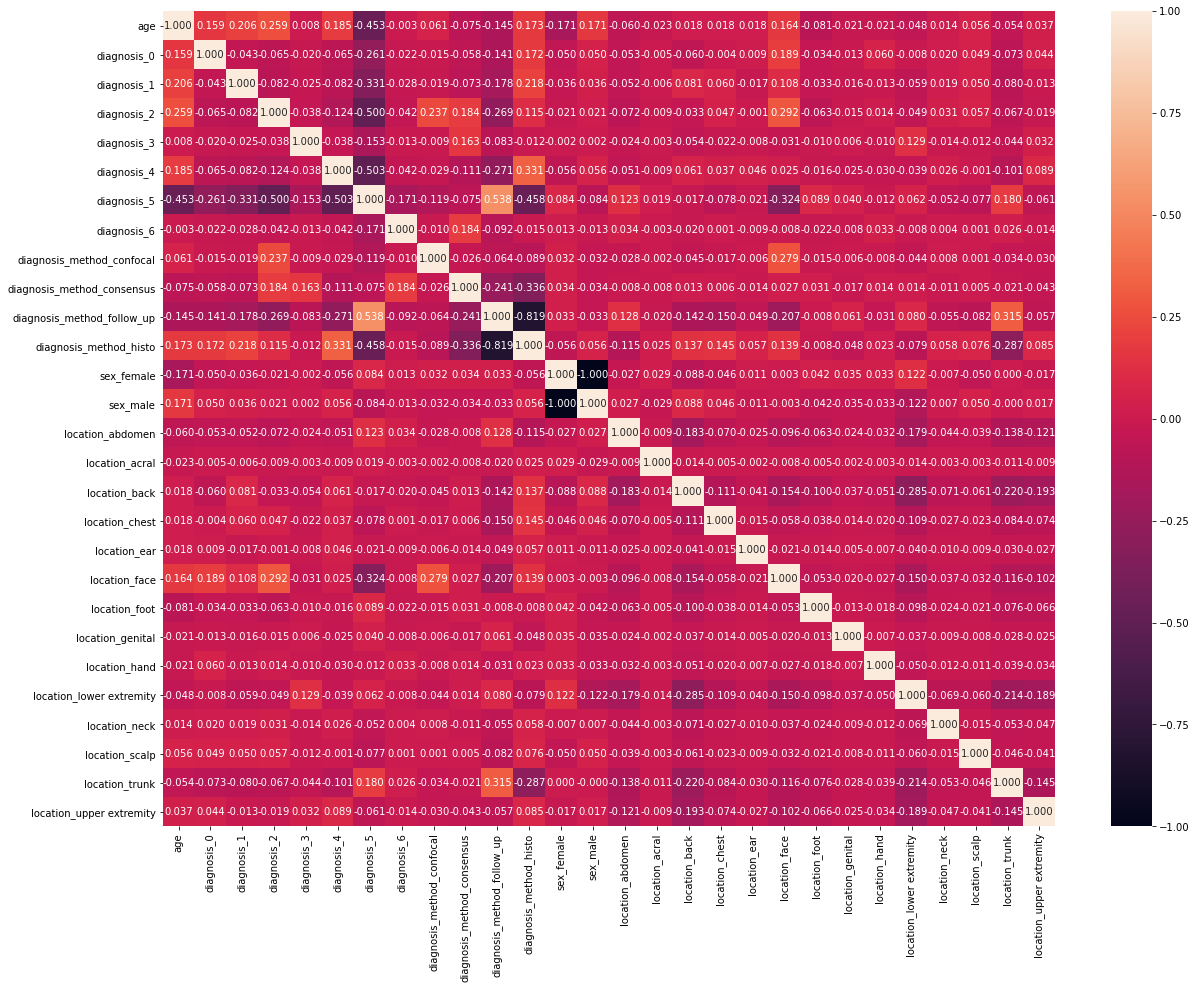

In [69]:
plt.figure(figsize=(20,15))
print('Correlation between continuous features')
p=sns.heatmap(metadata_cont.corr(), annot=True, fmt='.3f')

As can be seen from the correlation matrix, there are some positive and negative correlations between the features and the diagnoses. Already, these can give a hint as to what type of lesion a patient has based off of its features, such as location, age, and diagnosis method. Moving forward, I will first run a simple classification model using just the images and the diagnoses. Then I will create a wide and deep model which will pull in all the features associated with diagnosis to refine the model.

Let's now plot histograms of each column to see the spread of features data.

array([[<AxesSubplot:title={'center':'diagnosis'}>,
        <AxesSubplot:title={'center':'age'}>]], dtype=object)

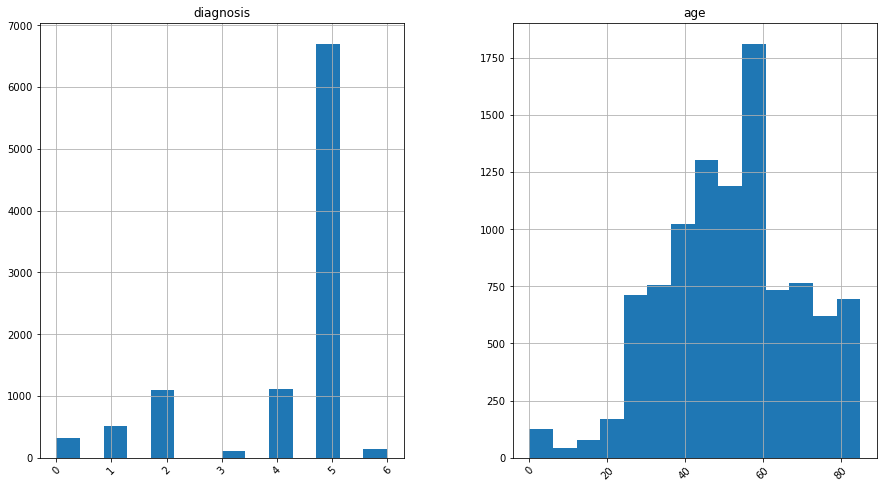

In [70]:
image_metadata.hist(bins=14, figsize=(15,8), xrot=45)

In [71]:
metadata_cont.describe()

,age,diagnosis_0,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,diagnosis_5,diagnosis_6,diagnosis_method_confocal,diagnosis_method_consensus,...,location_ear,location_face,location_foot,location_genital,location_hand,location_lower extremity,location_neck,location_scalp,location_trunk,location_upper extremity
count,10015.00000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,...,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000
mean,51.82027,0.032651,0.051323,0.109735,0.011483,0.111133,0.669496,0.014179,0.006890,0.090065,...,0.005592,0.074688,0.033350,0.004793,0.008987,0.217474,0.016775,0.012781,0.141887,0.113430
std,16.96831,0.177730,0.220667,0.312575,0.106546,0.314313,0.470418,0.118233,0.082722,0.286289,...,0.074571,0.262900,0.179558,0.069067,0.094375,0.412548,0.128433,0.112333,0.348952,0.317133
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,65.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,85.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Create the required datasets for the keras model.

In [72]:
#Create datasets for tensorflow keras
batch_size = 32
img_height = 450
img_width = 600
data_dir = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images'

In [73]:
train_images = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset='training', seed=47, image_size=(img_height, img_width), batch_size=batch_size)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.


In [74]:
val_images = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset='validation', seed=47, image_size=(img_height, img_width), batch_size=batch_size)

Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


In [75]:
class_names = train_images.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


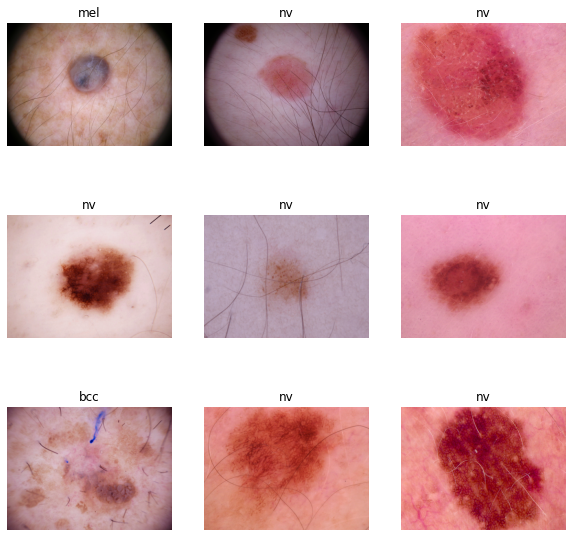

In [76]:
#First nine images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

At this point, I am ready to move forward with configuring the dataset for the keras model through standardization. I will then implement the model. After that, I will then move towards creating a wide and deep model using all the features from the image metadata.